# Slope Prediction for Feed-Forward Process Control (with previous slope and conc)
This is an explaination of what is in this notebook

## Set up
import neccessary packages and set current directory to lib. This will help with importing the data files

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

cur_dir = os.getcwd()
cur_dir

'/scratch/garrettroell/machine_learning_clostridium/slope_prediction_lib'

## Get Starting Data
This data was generated from the data processing notebook

In [2]:
smooth_data = pd.read_csv(f'{cur_dir}/processed_data/smooth_data.csv')
smooth_data.set_index(['composition','trial','time'], drop=True, inplace=True)
smooth_data.head()

CO    CO2     H2    acetate   biomass   butanol  \
composition trial time                                                     
1           1     0.2   0.5  0.375  0.125  19.831073  0.410803  0.028316   
                  0.3   0.5  0.375  0.125  22.196249  0.403602  0.031357   
                  0.4   0.5  0.375  0.125  25.293925  0.403709  0.028700   
                  0.5   0.5  0.375  0.125  29.005157  0.406214  0.031038   
                  0.6   0.5  0.375  0.125  32.899333  0.410848  0.043533   

                        butyrate    ethanol  flow rate  acetate_Δ  ...  \
composition trial time                                             ...   
1           1     0.2   0.051013  15.144135       20.0  18.298778  ...   
                  0.3   0.050367  14.522308       20.0  23.651756  ...   
                  0.4   0.035514  13.956015       20.0  30.976760  ...   
                  0.5   0.041123  13.322048       20.0  37.112317  ...   
                  0.6   0.081221  12.648214       20.0  38.941765  ...   

                        prev_acetate  prev_biomass  prev_butanol  \
composition trial time                                             
1           1     0.2      18.001195      0.421076      0.028260   
                  0.3      19.831073      0.410803      0.028316   
                  0.4      22.196249      0.403602      0.031357   
                  0.5      25.293925      0.403709      0.028700   
                  0.6      29.005157      0.406214      0.031038   

                        prev_butyrate  prev_ethanol  prev_acetate_Δ  \
composition trial time                                                
1           1     0.2        0.061033      0.028260       10.961665   
                  0.3        0.051013      0.028316       18.298778   
                  0.4        0.050367      0.031357       23.651756   
                  0.5        0.035514      0.028700       30.976760   
                  0.6        0.041123      0.031038       37.112317   

                        prev_biomass_Δ  prev_butanol_Δ  prev_butyrate_Δ  \
composition trial time                                                    
1           1     0.2        -0.084697       -0.015584        -0.144950   
                  0.3        -0.102733        0.000561        -0.100208   
                  0.4        -0.072009        0.030416        -0.006462   
                  0.5         0.001068       -0.026579        -0.148525   
                  0.6         0.025050        0.023385         0.056090   

                        prev_ethanol_Δ  
composition trial time                  
1           1     0.2        -0.144950  
                  0.3        -0.100208  
                  0.4        -0.006462  
                  0.5        -0.148525  
                  0.6         0.056090  

[5 rows x 24 columns]

Check that imports worked correctly

In [3]:
print(f'Shape of the smooth data: {smooth_data.shape[0]} rows by {smooth_data.shape[1]} columns')

Shape of the smooth data: 856 rows by 24 columns


## Create train/test/validation data sets
Train and test data comes from compostions 1-7.<br>
Validation data comes from compostions 8, 9, and 10.

In [4]:
train_test_data = smooth_data.loc[[1,2,3,4,5,6,7]]
print(f'Shape of the train_test data: {train_test_data.shape[0]} rows by {train_test_data.shape[1]} columns')
validation_data = smooth_data.loc[[8,9,10]]
print(f'Shape of the validation data: {validation_data.shape[0]} rows by {validation_data.shape[1]} columns')

Shape of the train_test data: 550 rows by 24 columns
Shape of the validation data: 306 rows by 24 columns


## Define a function that generates the X array and y array for ML model training

The parameter 'input_data' is used to specify whether raw data or the polynomial smoothed data will be used to train the model <br>
The parameter 'conditions_to_include' is a list of the conditions to include in the returned arrays

In [5]:
def get_X_y_arrays(data):

    data_copy = data.copy()
    data_copy.reset_index(inplace=True)
    X = data_copy [['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol', 'CO', 'CO2', 'H2', 'flow rate', 'prev_acetate', 'prev_biomass', 'prev_butanol', 'prev_butyrate', 'prev_ethanol', 'prev_acetate_Δ', 'prev_biomass_Δ', 'prev_butanol_Δ', 'prev_butyrate_Δ', 'prev_ethanol_Δ']]
    y = data_copy [['acetate_Δ', 'biomass_Δ', 'butanol_Δ', 'butyrate_Δ', 'ethanol_Δ']]
 
    return np.array(X), np.array(y)

Apply to train/test data and validation data set

In [6]:
X_train_test, y_train_test = get_X_y_arrays(train_test_data)
X_validation, y_validation = get_X_y_arrays(validation_data)

print(f'Shape of the train_test X array: {X_train_test.shape[0]} rows by {X_train_test.shape[1]} columns')
print(f'Shape of the train_test y array: {y_train_test.shape[0]} rows by {y_train_test.shape[1]} columns')
print(f'Shape of the validation X array: {X_validation.shape[0]} rows by {X_validation.shape[1]} columns')
print(f'Shape of the validation y array: {y_validation.shape[0]} rows by {y_validation.shape[1]} columns')

Shape of the train_test X array: 550 rows by 19 columns
Shape of the train_test y array: 550 rows by 5 columns
Shape of the validation X array: 306 rows by 19 columns
Shape of the validation y array: 306 rows by 5 columns


## Perform train_test_split on train/test data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=0.25, random_state=42)
print(f'Shape of the train X array: {X_train.shape[0]} rows by {X_train.shape[1]} columns')
print(f'Shape of the train y array: {y_train.shape[0]} rows by {y_train.shape[1]} columns')
print(f'Shape of the test  X array: {X_test.shape[0] } rows by {X_test.shape[1] } columns')
print(f'Shape of the test  y array: {y_test.shape[0] } rows by {y_test.shape[1] } columns')

Shape of the train X array: 412 rows by 19 columns
Shape of the train y array: 412 rows by 5 columns
Shape of the test  X array: 138 rows by 19 columns
Shape of the test  y array: 138 rows by 5 columns


Save y_train and y_test as dataframes. These will be used for prediction evaluation

In [8]:
train_data = pd.DataFrame(data=y_train, columns=['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol'])
test_data = pd.DataFrame(data=y_test, columns=['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol'])
print(f'Shape of the train data: {train_data.shape[0]} rows by {train_data.shape[1]} columns')
print(f'Shape of the test  data: {test_data.shape[0] } rows by {test_data.shape[1] } columns')

Shape of the train data: 412 rows by 5 columns
Shape of the test  data: 138 rows by 5 columns


## Train 25 different models using 5 algorithms for each of the 5 outputs
algorithms = gradient boosting, random forest, support vector, neural net, lasso <br>
outputs = acetate, biomass, butanol, butyrate, ethanol

In [9]:
from machine_learning.model_selector import model_selector

trained_models = {}
for regressor in ['gradient boosting', 'random forest', 'support vector', 'neural net', 'lasso']:
    print(regressor)
    model = model_selector(regressor)
    trained_models[regressor] = model.fit(X_train, y_train)

gradient boosting
random forest
support vector
neural net
lasso


## Get model predictions for train, test, and validation data sets
First define a function that takes in an X array and outputs a dictionary of prediction dataframes

In [10]:
def get_model_predictions(X_array):
    prediction_dfs = {}
    for regressor in ['gradient boosting', 'random forest', 'support vector', 'neural net', 'lasso']:
        model = trained_models[regressor]
        prediction_array = model.predict(X_array)
        prediction_dfs[regressor] = pd.DataFrame(data=prediction_array, columns=['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol'])
    return prediction_dfs

Apply function to get prediction dataframe 

In [11]:
train_predictions = get_model_predictions(X_train)
test_predictions = get_model_predictions(X_test)
validation_predictions = get_model_predictions(X_validation)

display(train_predictions['gradient boosting'].head())
display(test_predictions['lasso'].head())
display(validation_predictions['random forest'].head())

,acetate,biomass,butanol,butyrate,ethanol
0,-4.778606,0.003143,3.629732,2.591008,22.921263
1,8.762285,0.063137,0.818702,1.802243,7.816563
2,-3.948837,-0.036327,3.257579,-0.738267,15.960500
3,-4.535436,-0.006389,2.080504,2.289757,15.664006
4,-13.290744,0.001645,3.754316,1.639430,14.356236


,acetate,biomass,butanol,butyrate,ethanol
0,-16.852173,0.077234,9.409927,5.264097,18.435149
1,-8.179176,0.065434,4.263834,5.592506,5.547864
2,13.104471,0.000944,1.116473,5.036500,-1.290420
3,-2.377324,0.003550,12.566434,-7.613400,17.951118
4,-0.685786,0.002242,3.861440,0.741487,7.242918


,acetate,biomass,butanol,butyrate,ethanol
0,15.531055,-0.011345,-0.064556,-0.032930,-3.036243
1,17.764806,0.055620,-0.061353,0.018604,-3.527030
2,23.345800,0.106106,-0.066029,0.067874,3.391897
3,19.884024,0.061200,0.072165,0.432007,-2.203175
4,16.668202,0.098819,0.279574,0.673066,1.844372


## Evaluate Model Fits
Define functions to evaluated r squared and normalized root mean squared error

In [12]:
from scipy.stats import linregress
from sklearn import metrics

def get_pearson_r2 (measured_list, predicted_list):
    # slope, intercept, r_value, p_value, std_err
    _, _, r_value, _, _ = linregress(measured_list, predicted_list)
    r2 = (r_value**2)
    return r2

def get_norm_rmse (measured_list, predicted_list):
    mse = metrics.mean_squared_error(measured_list, predicted_list)
    rmse = (mse**0.5)
    avg_meas = sum(measured_list) / len(measured_list) 
    return abs(rmse/avg_meas)

Define a function to evaluate the r squared value for each model and data set for a given output (acetate, biomass, ...)

In [13]:
def evaluate_models(output, metric):
    data = {}
    for dataset in ['Train', 'Test', 'Validation']:
        data[dataset] = []
        for model in ['gradient boosting', 'random forest', 'support vector', 'neural net', 'lasso']:
            
            if dataset == 'Train':
                prediction_values = train_predictions[model][output]
                measured_values = train_data[output]
            elif dataset == 'Test':
                prediction_values = test_predictions[model][output]
                measured_values = test_data[output]
            elif dataset == 'Validation':
                prediction_values = validation_predictions[model][output]
                measured_values = validation_data[output]
            else:
                print('Something went wrong')
                
            if metric == 'r2':
                data[dataset].append(get_pearson_r2(prediction_values, measured_values))
            elif metric == 'norm_rmse':
                data[dataset].append(get_norm_rmse(prediction_values, measured_values))
            else:
                print('Something went wrong')
                
    data_table = pd.DataFrame.from_dict(data)
    data_table[f'{output} {metric}'] = ['gradient boosting', 'random forest', 'support vector', 'neural net', 'lasso']
    data_table.set_index(f'{output} {metric}', inplace=True, drop=True)
        
    return data_table

## Plot evaluation metrics
Plot r$^2$ values first

Apply function to all outputs and metrics (Not needed, but the details are there if 

In [14]:
def plot_evaluation_metrics(output, metric):
    labels = ['gradient boosting', 'random forest', 'support vector', 'neural net', 'lasso']
    train_data = list(evaluate_models(output, metric)['Train'])
    test_data = list(evaluate_models(output, metric)['Test'])
    validation_data = list(evaluate_models(output, metric)['Validation'])

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(8,5))
    rects1 = ax.bar(x - width, train_data,      width, label='Train')
    rects2 = ax.bar(x,         test_data,       width, label='Test')
    rects3 = ax.bar(x + width, validation_data, width, label='Validation')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(f'{metric}')
    ax.set_title(f'{metric} values for {output} slope predictions (with previous slope and conc)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


    fig.tight_layout()
    plt.savefig(f'figures_with_previous_slope_and_conc/with_previous_slope_and_conc_{metric}_{output}_values.png', dpi=100)
    plt.show()

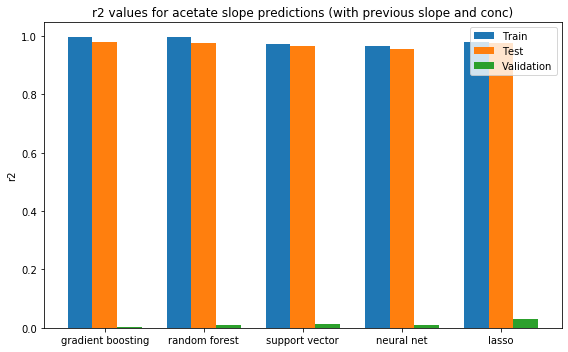

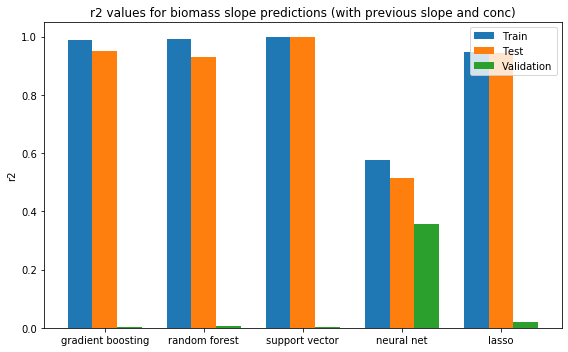

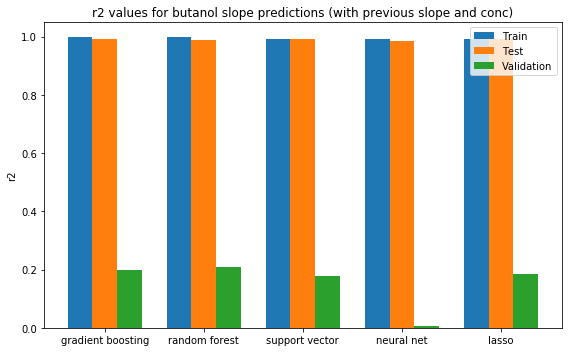

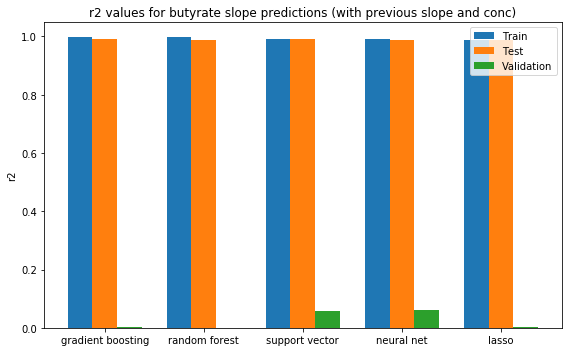

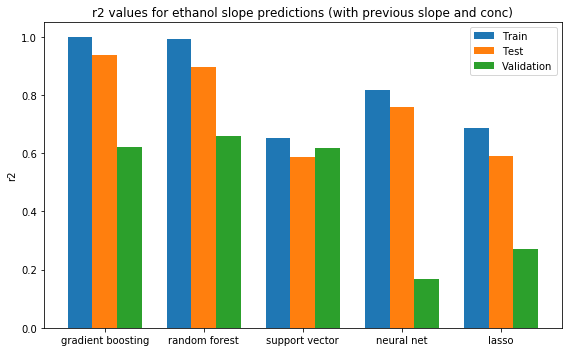

In [15]:
for output in ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']:
    plot_evaluation_metrics(output, 'r2')

Plot normalized mean squared error

In [16]:
# for output in ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']:
#     plot_evaluation_metrics(output, 'norm_rmse')

## Plot scatterplots of slope fits

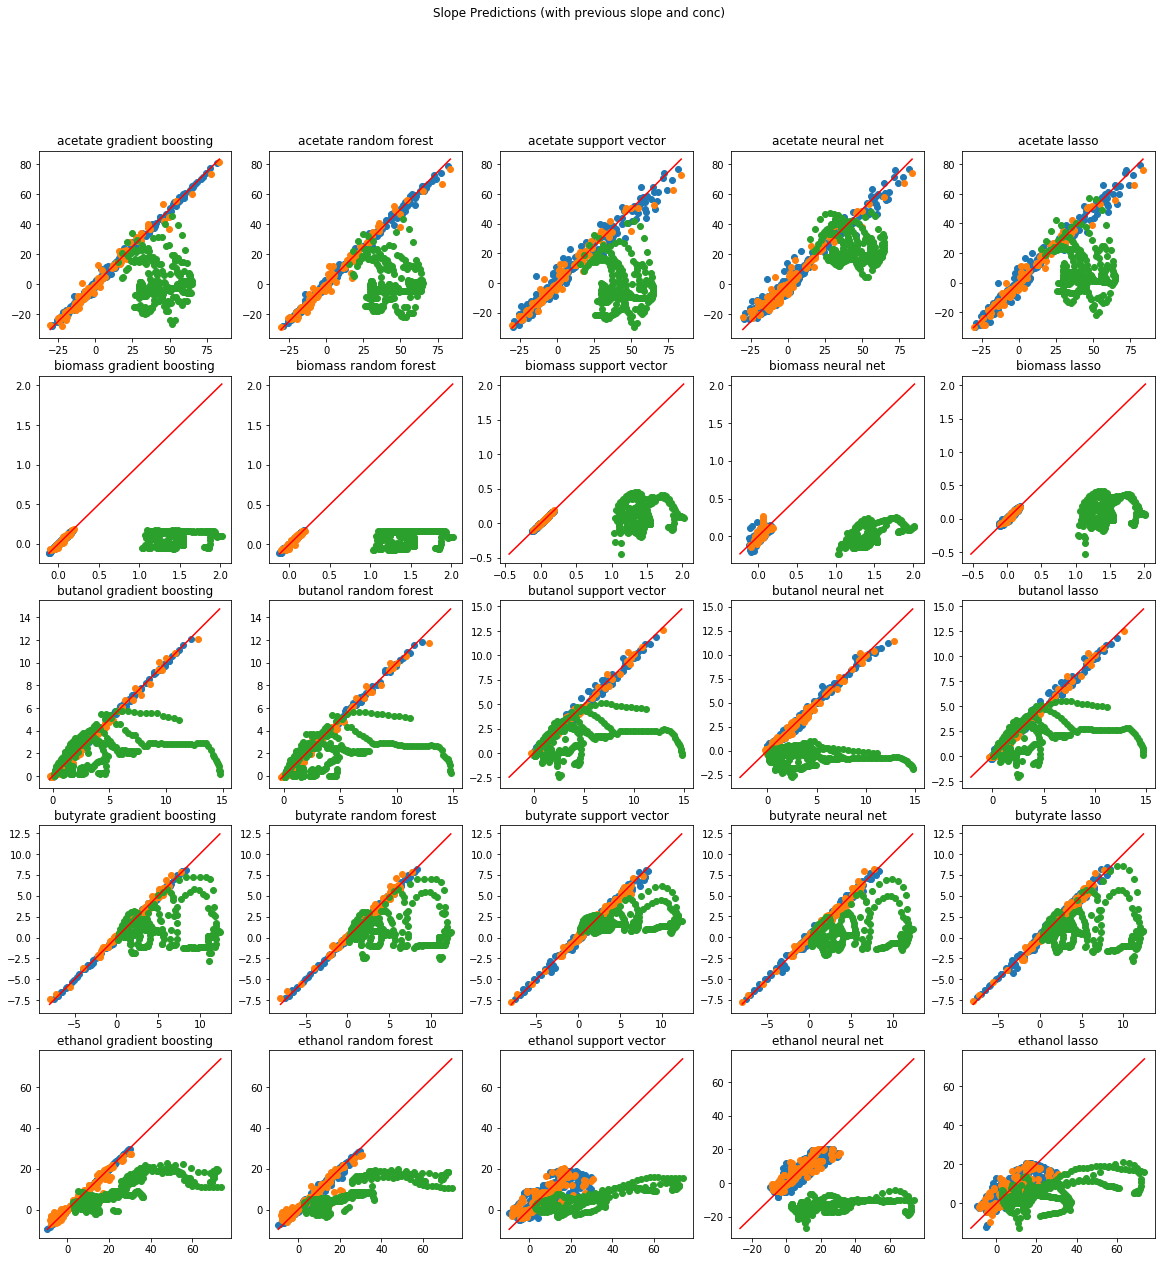

In [17]:
outputs = ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']
models = ['gradient boosting', 'random forest', 'support vector', 'neural net', 'lasso']

fig, ax = plt.subplots(5, 5, figsize=(20,20))
fig.suptitle(f'Slope Predictions (with previous slope and conc)')

for x in range(5):
    for y in range(5):
        ax[x, y].title.set_text(f'{outputs[x]} {models[y]}')
        
        ax[x, y].scatter(train_data[outputs[x]], train_predictions[models[y]][outputs[x]])
        ax[x, y].scatter(test_data[outputs[x]], test_predictions[models[y]][outputs[x]])
        ax[x, y].scatter(validation_data[outputs[x]], validation_predictions[models[y]][outputs[x]])
        
        minimum = min(pd.concat([
            validation_data[outputs[x]],
            test_data[outputs[x]],
            train_data[outputs[x]], 
            validation_predictions[models[y]][outputs[x]],
            test_predictions[models[y]][outputs[x]],
            train_predictions[models[y]][outputs[x]]
        ], axis=0))

        maximum = max(pd.concat([
            validation_data[outputs[x]],
            test_data[outputs[x]],
            train_data[outputs[x]],
            validation_predictions[models[y]][outputs[x]],
            test_predictions[models[y]][outputs[x]],
            train_predictions[models[y]][outputs[x]]
        ], axis=0))

        ax[x, y].plot([minimum, maximum], [minimum, maximum], 'r') #row=0, col=0

plt.savefig('figures_with_previous_slope_and_conc/with_previous_slope_and_conc_slope_scatterplots.png', dpi=100)
plt.show()

## Feature Importance
Define a function to get feature importances

In [18]:
def get_feature_importances(model):
    outputs = ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']
    features = ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol', 'CO', 'CO2', 'H2', 'flow rate', 'prev_acetate', 'prev_biomass', 'prev_butanol', 'prev_butyrate', 'prev_ethanol', 'prev_acetate_Δ', 'prev_biomass_Δ', 'prev_butanol_Δ', 'prev_butyrate_Δ', 'prev_ethanol_Δ']

    array_list = []

    for i in range(5):
        feature_importance_array = model.estimators_[i].steps[1][1].best_estimator_.feature_importances_
        array_list.append(list(feature_importance_array))
    df = pd.DataFrame(array_list, columns = features, index = outputs)  
    return df

Get feature importance values

In [19]:
model_list = [
    trained_models['gradient boosting'],
    trained_models['random forest'],
    ]

for model in model_list:
    display(get_feature_importances(model))

,acetate,biomass,butanol,butyrate,ethanol,CO,CO2,H2,flow rate,prev_acetate,prev_biomass,prev_butanol,prev_butyrate,prev_ethanol,prev_acetate_Δ,prev_biomass_Δ,prev_butanol_Δ,prev_butyrate_Δ,prev_ethanol_Δ
acetate,0.001625,0.005859,0.011309,0.008117,0.001260,0.000316,0.000138,0.000204,0.000000e+00,0.002436,0.000876,0.000360,0.037048,0.000308,0.910002,0.001672,0.018136,0.000073,0.000261
biomass,0.019285,0.000593,0.000873,0.002394,0.002055,0.000041,0.000092,0.001933,0.000000e+00,0.002041,0.002907,0.000848,0.009549,0.001125,0.017724,0.930368,0.004849,0.001451,0.001874
butanol,0.000230,0.000500,0.000976,0.000142,0.000244,0.000007,0.000002,0.000276,0.000000e+00,0.001077,0.000499,0.000243,0.000156,0.000423,0.000540,0.000420,0.993342,0.000385,0.000539
butyrate,0.000241,0.000723,0.000140,0.000296,0.001281,0.000009,0.000011,0.000000,0.000000e+00,0.000918,0.000306,0.002369,0.003297,0.001327,0.002080,0.000364,0.005531,0.349126,0.631982
ethanol,0.008318,0.178880,0.006550,0.014651,0.521548,0.003644,0.006205,0.001041,5.820370e-07,0.038456,0.014957,0.023430,0.014232,0.014075,0.015083,0.020899,0.102814,0.010669,0.004547


,acetate,biomass,butanol,butyrate,ethanol,CO,CO2,H2,flow rate,prev_acetate,prev_biomass,prev_butanol,prev_butyrate,prev_ethanol,prev_acetate_Δ,prev_biomass_Δ,prev_butanol_Δ,prev_butyrate_Δ,prev_ethanol_Δ
acetate,0.001381,0.002996,0.002593,0.004877,0.002353,0.000274,0.000621,0.000203,0.000176,0.001744,0.001609,0.001282,0.003501,0.001449,0.961347,0.002571,0.004762,0.003361,0.002898
biomass,0.009431,0.002602,0.004662,0.004536,0.003686,0.000616,0.001041,0.000885,0.000177,0.004139,0.002650,0.002371,0.004011,0.002445,0.008902,0.935749,0.007361,0.002376,0.002360
butanol,0.000539,0.000403,0.000413,0.001125,0.000484,0.000047,0.000238,0.000122,0.000005,0.000628,0.000369,0.000505,0.001230,0.000343,0.002154,0.000692,0.989457,0.000611,0.000635
butyrate,0.004674,0.000665,0.001314,0.001649,0.001382,0.000083,0.000206,0.000221,0.000037,0.004140,0.000759,0.000962,0.002053,0.001229,0.002741,0.001252,0.001259,0.504295,0.471079
ethanol,0.015987,0.070776,0.011537,0.012873,0.528059,0.002764,0.008930,0.003753,0.000082,0.023233,0.034997,0.015073,0.021325,0.013566,0.014938,0.023445,0.173901,0.012936,0.011827


Define a function to plot feature importance

In [20]:
def plot_feature_importance(model_name):
    model = trained_models[model_name]
    data = get_feature_importances(model)
    acetate_data = data.iloc[0]
    biomass_data = data.iloc[1]
    butanol_data = data.iloc[2]
    butyrate_data = data.iloc[3]
    ethanol_data = data.iloc[4]
    
    labels = ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol', 'CO', 'CO2', 'H2', 'flow rate', 'prev_acetate', 'prev_biomass', 'prev_butanol', 'prev_butyrate', 'prev_ethanol', 'prev_acetate_Δ', 'prev_biomass_Δ', 'prev_butanol_Δ', 'prev_butyrate_Δ', 'prev_ethanol_Δ']
    
    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars

    fig, ax = plt.subplots(figsize=(20,5))
    rects1 = ax.bar(x - 2*width, acetate_data , width, label='Δ Acetate')
    rects2 = ax.bar(x -   width, biomass_data , width, label='Δ Biomass')
    rects3 = ax.bar(x          , butanol_data , width, label='Δ Butanol')
    rects4 = ax.bar(x +   width, butyrate_data, width, label='Δ Butyrate')
    rects5 = ax.bar(x + 2*width, ethanol_data , width, label='Δ Ethanol')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(f'Importance')
    ax.set_title(f'Feature Importance for {model_name} Slope Predictions (with previous slope and conc)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    fig.tight_layout()
    plt.savefig(f'figures_with_previous_slope_and_conc/with_previous_slope_and_conc_feature_importance_{model_name}.png', dpi=100)
    plt.show()

Plot feature importance gradient boosting and random forest

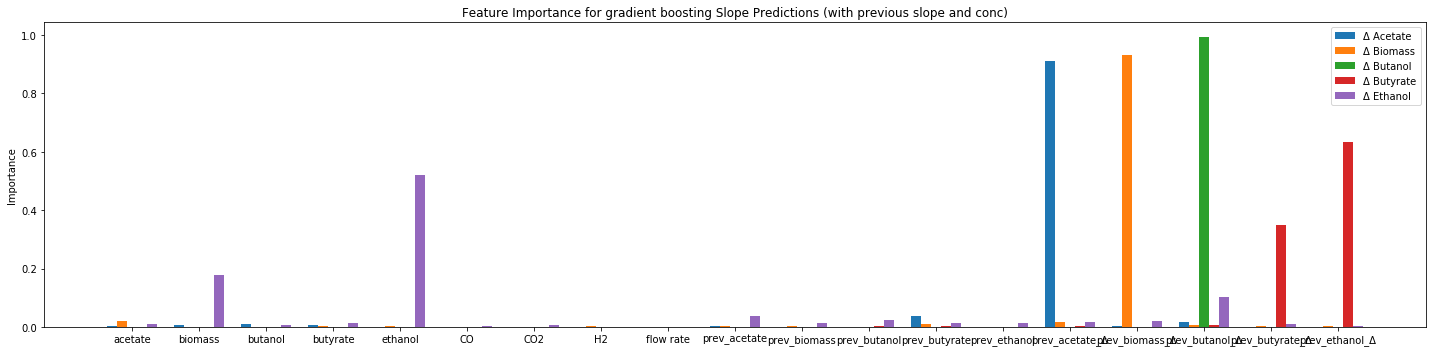

In [21]:
plot_feature_importance('gradient boosting')

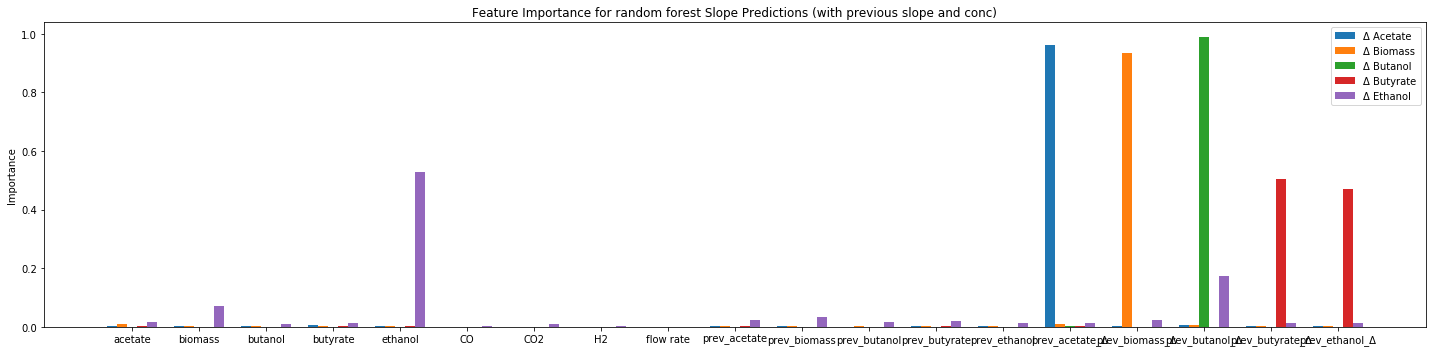

In [22]:
plot_feature_importance('random forest')